In [1]:
import openpyxl as px # работа с  xlsx файлами
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics, pipeline, preprocessing
from sklearn.ensemble import RandomForestRegressor 
from sklearn import tree
from sklearn.tree import export_graphviz # рисуем дерево
#import pydot 
import dill # библиотека для сохранения дерева в png

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Обработка данных и обучение модели, проверка на тестовой выборке
def model():
    # файл с данными
    data_file = u'!ЖК FRESH.xlsx'
    wb = px.load_workbook(data_file)
    
    # имя рабочего листа   
    work_sheet = u'ЖК' 
    sheet = wb[work_sheet]
    
    # считываем данные их Exel в питон
    df = pd.DataFrame(sheet.values)
    #print (df.head())
    
    # удаляем 0-вую строку
    df = df.drop([0], axis=0)
    #print (df.head())
    
    # Формирование матрицы признаков и целевой переменной
    
    n = 10 # номер столбца с целевой переменной
    data = df.drop(n, 1)
    labels = df[n].values
    
    # Разделение на train и test
    (train_data, test_data, train_labels, test_labels) = train_test_split(data, labels, test_size=0.3, random_state=0)
    
    # Категориальные признаки
    categorical_data = train_data.drop([0, 1, 2, 3, 4], 1) 
    categorical_data_indices = np.array([(column in categorical_data) for column in train_data.columns], dtype = bool)
    
    # Числовые признаки
    numeric_data = train_data.drop([ 5, 6, 7, 8, 9], 1) 
    numeric_data_indices = np.array([(column in numeric_data) for column in train_data.columns], dtype = bool)
    
    # Выбор регрессора (случайный лес)
    regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)
    
    # Создаем список преобразований
    estimator = pipeline.Pipeline(steps = [       
        ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
                    
                #numeric
                ('numeric_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data1: data1[:, numeric_data_indices], validate=True)),
                    ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                            ])),
                #categorical
                ('categorical_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data1: data1[:, categorical_data_indices], validate=True)),
                    ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                            ])),
    
            ])),
        ('model_fitting', regressor)
        ]
    )
    
    # Обучение модели
    estimator.fit(train_data, train_labels)
    
    error = metrics.mean_absolute_error(test_labels, estimator.predict(test_data))
    
    pylab.figure(figsize=(16, 6))

    pylab.subplot(1,2,2)
    pylab.grid(True)
    pylab.xlim(0,20000000)
    pylab.ylim(0,20000000)
    pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
    pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
    
    return error, estimator

In [4]:
# Делаем прогноз
def predict(estimator):

    data_file = u'Фреш_проект.xlsx'
    work_sheet = u'ЖК' 
    wb = px.load_workbook(data_file, data_only=True)
    sheet = wb[work_sheet]
    for k in range(1546):
        new_data = []
        for i in range(10):
            new_data.append(float(sheet.cell(row = k + 2, column = i + 1).value))
        new_data = array(new_data)
        new_data = new_data.reshape(1, -1)
        answer = estimator.predict(new_data)
        sheet.cell(row = k+2, column = 11).value = answer[0]
    wb.save("Пробник2.xlsx") 

In [5]:
# Сохранение дерева в png
def print_save_tree():
    names = ["Этаж",                           
             "Количество комнат",   
             "Общая площадь",  
             "Жилая площадь",  
             "Площадь кухни",  
             "Этажность корпуса 27",   
             "Этажность корпуса 30",  
             "Внутренняя отделка -",    
             "Внутренняя отделка +",
             "Тип планировки - типовой",   
             "Тип планировки - евро",
             "Количество сан узлов 1",   
             "Количество сан узлов 2", 
             "Сан узел - совм", 
             "Сан узел - разд",
             "Сан узел - совм и разд",
            ]
    export_graphviz(estimator.named_steps['model_fitting'][0], 
                    out_file='tree.dot', feature_names = names, filled=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    graph.write_png('tree.png')

203288.0


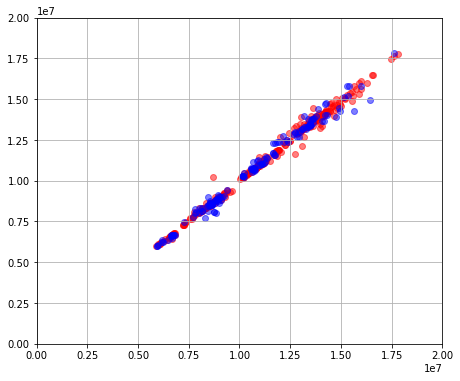

In [6]:
err, estimator = model()
print (round(err))
predict(estimator)

In [7]:
# Сохраняем обученную модель в файл для дальнейшего использования
with open('file.pkl', 'wb') as fid:
    dill.dump(estimator, fid) 